# Mask R-CNN for Keypoint Detection

Example showing how to do keypoint detection with Mask R-CNN

In [1]:
USE_GPU = False
TRAIN   = True

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Datasets for Keypoint Detection

In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
#keypoints_to_include = ['nose', 'left_shoulder', 'right_shoulder',
#                        'left_elbow', 'right_elbow', 'left_wrist',
#                        'right_wrist', 'left_hip', 'right_hip',
#                        'left_knee', 'right_knee', 'left_ankle',
#                        'right_ankle']
keypoints_to_include = ["nose", "right_wrist"]

dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_val.prepare()

Will use images in A:/Programming/DeepLearningDatasets/coco/train2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=11.08s)
creating index...
index created!
Will use images in A:/Programming/DeepLearningDatasets/coco/val2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


### Setup Training

In [3]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1 # IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 1000 if USE_GPU else 1000
    
    TRAIN_ROIS_PER_IMAGE = 100
    #MAX_GT_INSTANCES = 1
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
NAM

## Train

In [4]:
if TRAIN:
    importlib.reload(modellib)

    # Create model
    print("Creating model...")
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
                       #exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_mask"])

Creating model...

build:
input_gt_boxes.shape (?, ?, 4)
input_gt_kp_ids.shape (?, ?, 2)
input_gt_masks.shape (?, ?, 2)
gt_masks.shape (?, 2)
masks.shape (?, 2)
kps_1d_indices.shape (?,)
kps_x.shape (?, ?)
kps_x.shape (?, ?)
resized_kps_x.shape (?, ?)
kps_indices.shape (?, ?)
masks.shape (?, ?)
target_mask.shape (1, ?, ?)
target_mask.dtype <dtype: 'int32'>
mrcnn_mask.shape (?, 100, 2, 28, 28)

mrcnn_mask_loss_graph shapes:
target_masks.shape (1, ?, ?)
target_masks.dtype <dtype: 'int32'>
target_kp_ids.shape (1, ?, ?)
pred_masks.shape (?, 100, 2, 28, 28)
y_true.shape (?,)
y_pred.shape (?, ?)


mrcnn_mask_loss_graph shapes:
target_masks.shape (?, 100, 2)
target_masks.dtype <dtype: 'int32'>
target_kp_ids.shape (?, 2)
pred_masks.shape (?, 100, 2, 28, 28)
y_true.shape (?,)
y_pred.shape (?, ?)



In [5]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 1
    print("Training network heads...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=4,
                layers="heads",
                augmentation=None)

Training network heads...

Starting at epoch 0. LR=0.001

Checkpoint Path: A:\Programming\Pose_RCNN\logs\coco_keypoints20180602T0350\mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_

c:\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
 144/1000 [===>..........................] - ETA: 2:18:19 - loss: 4.6328 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.9189 - mrcnn_bbox_loss: 0.5962 - mrcnn_mask_loss: 3.0592

ERROR:root:Error processing image {'id': 260050, 'source': 'coco', 'path': 'A:/Programming/DeepLearningDatasets/coco/train2017\\000000260050.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[284.76, 465.98, 284.76, 388.31, 277.21, 375.37, 277.21, 358.11, 292.31, 344.09, 295.55, 327.91, 297.71, 322.52, 308.49, 327.91, 309.57, 343.01, 312.81, 362.43, 312.81, 395.87, 313.89, 412.04, 319.28, 431.46, 304.18, 468.13]], 'num_keypoints': 13, 'area': 3931.859, 'iscrowd': 0, 'keypoints': [311, 336, 1, 0, 0, 0, 309, 334, 1, 0, 0, 0, 303, 334, 2, 287, 347, 1, 302, 350, 2, 0, 0, 0, 310, 379, 2, 0, 0, 0, 313, 402, 2, 283, 395, 1, 294, 397, 2, 288, 436, 2, 314, 430, 2, 290, 468, 1, 298, 467, 2], 'image_id': 260050, 'bbox': [277.21, 322.52, 42.07, 145.61], 'category_id': 1, 'id': 198640}, {'segmentation': [[490.39, 395.77, 486.82, 377.41, 474.58, 369.75, 480.7, 361.08, 488.35, 355.47, 491.41, 354.96, 493.45, 345.77, 499.58, 344.75, 500.6, 345.77, 506.21, 356.49, 511.82, 362.61, 515

1000/1000 [==============================] - 9740s 10s/step - loss: 4.2399 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 0.7937 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 2.9247 - val_loss: 4.2998 - val_rpn_class_loss: 0.0443 - val_rpn_bbox_loss: 0.5314 - val_mrcnn_bbox_loss: 0.4111 - val_mrcnn_mask_loss: 3.3129

ERROR:root:Error processing image {'id': 64240, 'source': 'coco', 'path': 'A:/Programming/DeepLearningDatasets/coco/train2017\\000000064240.jpg', 'width': 640, 'height': 384, 'annotations': [{'segmentation': [[3.45, 252.84, 18.98, 209.69, 36.24, 181.21, 45.73, 150.15, 45.73, 148.42, 25.89, 129.44, 23.3, 101.82, 44.01, 82.84, 64.72, 85.43, 87.16, 101.82, 88.88, 116.49, 97.51, 119.95, 127.71, 145.83, 133.75, 160.5, 148.42, 182.08, 153.6, 199.33, 153.6, 228.67, 169.13, 255.42, 164.82, 255.42, 151.01, 250.25, 151.01, 234.71, 137.2, 220.91, 125.12, 204.51, 108.73, 202.79, 76.8, 216.59, 43.15, 241.62, 42.28, 246.8, 50.05, 267.51, 64.72, 297.71, 73.35, 314.1, 48.32, 322.73, 33.65, 328.77, 31.93, 328.77, 38.83, 319.28, 31.93, 289.08, 6.9, 267.51]], 'num_keypoints': 14, 'area': 15876.7811, 'iscrowd': 0, 'keypoints': [47, 119, 2, 51, 112, 2, 41, 119, 2, 65, 108, 2, 0, 0, 0, 62, 132, 2, 102, 136, 2, 52, 173, 2, 0, 0, 0, 33, 212, 2, 0, 0, 0, 88, 206, 2, 131, 205, 2, 20, 239, 2, 151, 246, 1, 54, 30

1000/1000 [==============================] - 9720s 10s/step - loss: 4.0496 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.7511 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 2.8863 - val_loss: 4.0141 - val_rpn_class_loss: 0.0402 - val_rpn_bbox_loss: 0.7359 - val_mrcnn_bbox_loss: 0.3268 - val_mrcnn_mask_loss: 2.9111

ERROR:root:Error processing image {'id': 365485, 'source': 'coco', 'path': 'A:/Programming/DeepLearningDatasets/coco/train2017\\000000365485.jpg', 'width': 640, 'height': 439, 'annotations': [{'segmentation': [[94.98, 323.06, 95.45, 324.38, 96.2, 326.16, 95.82, 327.76, 95.17, 329.55, 94.88, 330.02, 94.22, 329.36, 94.13, 327.39, 93.47, 326.16, 93.94, 323.91, 94.32, 323.15]], 'num_keypoints': 0, 'area': 11.2708, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 365485, 'bbox': [93.47, 323.06, 2.73, 6.96], 'category_id': 1, 'id': 2016007}, {'segmentation': [[98.95, 327.08, 99.15, 328.44, 99.15, 328.44, 100.31, 328.95, 99.3, 334.54, 97.84, 334.84, 97.89, 331.47, 97.49, 330.26, 97.69, 329, 98.14, 328.34, 97.79, 327.44, 97.84, 326.78, 98.59, 326.63]], 'num_keypoints': 0, 'area': 14.44185, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 300/1000 [========>.....................] - ETA: 1:52:19 - loss: 4.2573 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.7249 - mrcnn_bbox_loss: 0.3403 - mrcnn_mask_loss: 3.1495

ERROR:root:Error processing image {'id': 357478, 'source': 'coco', 'path': 'A:/Programming/DeepLearningDatasets/coco/train2017\\000000357478.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[181.79, 415.79, 181.79, 406.54, 179.65, 398, 176.81, 384.48, 176.1, 375.23, 171.83, 380.21, 165.42, 384.48, 163.29, 385.19, 152.61, 382.35, 142.65, 374.52, 144.78, 365.98, 146.21, 353.17, 151.9, 316.87, 154.04, 292.68, 159.73, 252.83, 156.88, 244.29, 160.44, 217.24, 164, 205.15, 159.73, 195.9, 148.34, 183.8, 135.53, 161.74, 131.26, 131.85, 144.78, 97.69, 159.02, 87.01, 174.67, 80.61, 199.58, 84.17, 222.35, 92.71, 237.3, 116.19, 243.7, 150.35, 252.95, 163.16, 257.94, 183.8, 252.24, 187.36, 267.9, 195.18, 283.56, 210.13, 284.98, 224.36, 289.25, 235.04, 283.56, 240.73, 280, 249.98, 274.3, 255.67, 269.66, 307.24, 273.98, 336.36, 278.29, 365.48, 276.13, 395.69, 280.45, 423.73, 291.24, 433.44, 185.53, 433.44]], 'num_keypoints': 8, 'area': 39104.4773, 'iscrowd': 0, 'keypoints': [178, 1

 830/1000 [=======================>......] - ETA: 27:24 - loss: 4.0519 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.7013 - mrcnn_bbox_loss: 0.3421 - mrcnn_mask_loss: 2.9676  

ERROR:root:Error processing image {'id': 430529, 'source': 'coco', 'path': 'A:/Programming/DeepLearningDatasets/coco/train2017\\000000430529.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[290.61, 206.9, 290.27, 201.19, 292.29, 197.99, 294.47, 193.46, 298.17, 195.14, 300.69, 197.66, 300.35, 203.88, 301.03, 208.75, 300.35, 213.79, 298.51, 220.85, 298.84, 230.43, 296.49, 233.96, 288.42, 230.6, 291.95, 219, 291.28, 215.64]], 'num_keypoints': 0, 'area': 336.49295, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 430529, 'bbox': [288.42, 193.46, 12.61, 40.5], 'category_id': 1, 'id': 528861}, {'segmentation': [[434.16, 192.53, 434.01, 195.22, 433.21, 195.14, 432.98, 192.92, 432.66, 191.42, 433.61, 190.07, 434.16, 192.37]], 'num_keypoints': 0, 'area': 4.9678, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1000/1000 [==============================] - 9775s 10s/step - loss: 4.0465 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7307 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 2.9281 - val_loss: 5.1211 - val_rpn_class_loss: 0.0444 - val_rpn_bbox_loss: 0.6131 - val_mrcnn_bbox_loss: 0.3501 - val_mrcnn_mask_loss: 4.1135

ERROR:root:Error processing image {'id': 239337, 'source': 'coco', 'path': 'A:/Programming/DeepLearningDatasets/coco/train2017\\000000239337.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[409.63, 276.98, 406.89, 277.79, 406.18, 277.08, 406.18, 275.76, 406.07, 274.14, 405.46, 272.41, 405.46, 270.58, 405.77, 268.76, 405.87, 267.54, 406.48, 266.22, 408.21, 267.43, 408.21, 271.7, 408.82, 274.95]], 'num_keypoints': 0, 'area': 28.87935, 'iscrowd': 0, 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 239337, 'bbox': [405.46, 266.22, 4.17, 11.57], 'category_id': 1, 'id': 195168}, {'segmentation': [[386.97, 278.24, 386.49, 276.2, 386.37, 275.12, 386.25, 273.56, 385.77, 272.48, 386.61, 269.96, 386.61, 268.64, 386.97, 268.04, 388.41, 267.92, 389.13, 270.56, 388.65, 271.4, 388.53, 273.32, 388.53, 274.76, 389.25, 278.12, 389.01, 278.6, 387.69, 278.

Exception: INFO: Image with ID 54245 produced erroneus bbox x1 == x2

In [ ]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 2
    # Finetune layers from ResNet stage 4 and up
    print("Fine tune Resnet stage 4 and up...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=12,
                layers="4+",
                augmentation=None)

In [ ]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 3
    # Fine tune all layers
    print("Fine tune all layers...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE / 10,
                epochs=16,
                layers="all",
                augmentation=None)
    
    # Training done
    print("Training done")

Explanation of losses:

- rpn_class_loss: "How well does the network separate positive from negative anchors?"
- rpn_bbox_loss: "How accurate are proposed the bounding boxes?"
- mrcnn_class_loss: "How well does the network distinguish people from background RoIs?" (really, this is the same as 1.)
- mrcnn_bbox_loss: "Bounding box refinement loss" (is this the same as 2.?)
- mrcnn_mask_loss: "How accurate are the predicted keypoints?" (per mask softmax cross-entropy loss)

In [3]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    #MAX_GT_INSTANCES = 2
    
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
N

In [4]:
importlib.reload(modellib)
importlib.reload(utils)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  A:\Programming\Pose_RCNN\logs\coco_keypoints20180602T0350\mask_rcnn_coco_keypoints_0003.h5


## Inspect Model

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 2)                min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 2)                min: 224778.00000  max: 311704.00000  int32
masks                    shape: (1, 2, 1024, 1024)    min:    0.00000  max:    1.00000  bool


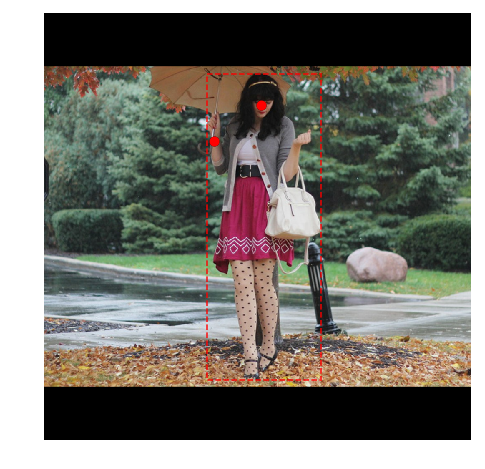

In [5]:
importlib.reload(visualize)

# Load a test image
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, image_id)

masks = []
for i in range(gt_kp_masks.shape[0]):
    msks = []
    for j in range(gt_kp_masks.shape[1]):
        mask = np.zeros((image.shape[:2]), dtype=np.bool)
        k = gt_kp_masks[i, j]
        mask[k // mask.shape[1], k % mask.shape[1]] = True
        msks.append(mask)
    masks.append(msks)
masks = np.array(masks)
    
log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)
log("masks", masks)

visualize.display_keypoints(image, gt_bbox, masks, gt_kp_ids,
                            #skeleton=dataset_train.skeleton,
                            figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mrcnn_mask.shape (1, 100, 2, 28, 28)
mrcnn_mask.dtype float32
detections.shape (100, 6)
mrcnn_mask.shape (100, 2, 28, 28)
masks.shape (94, 2, 28, 28)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
class_ids                shape: (94,)                 min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int32
bbox                     shape: (94, 4)               min:    0.00000  max:  866.00000  int32
masks                    shape: (94, 2, 1024, 1024)   min:    0.00000  max

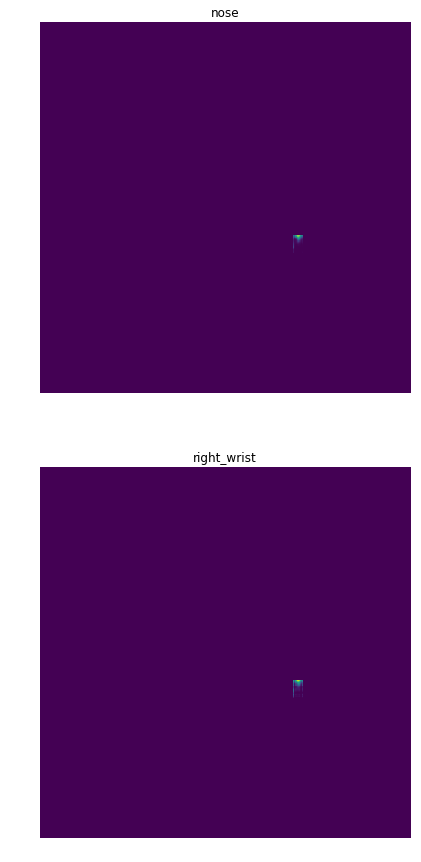

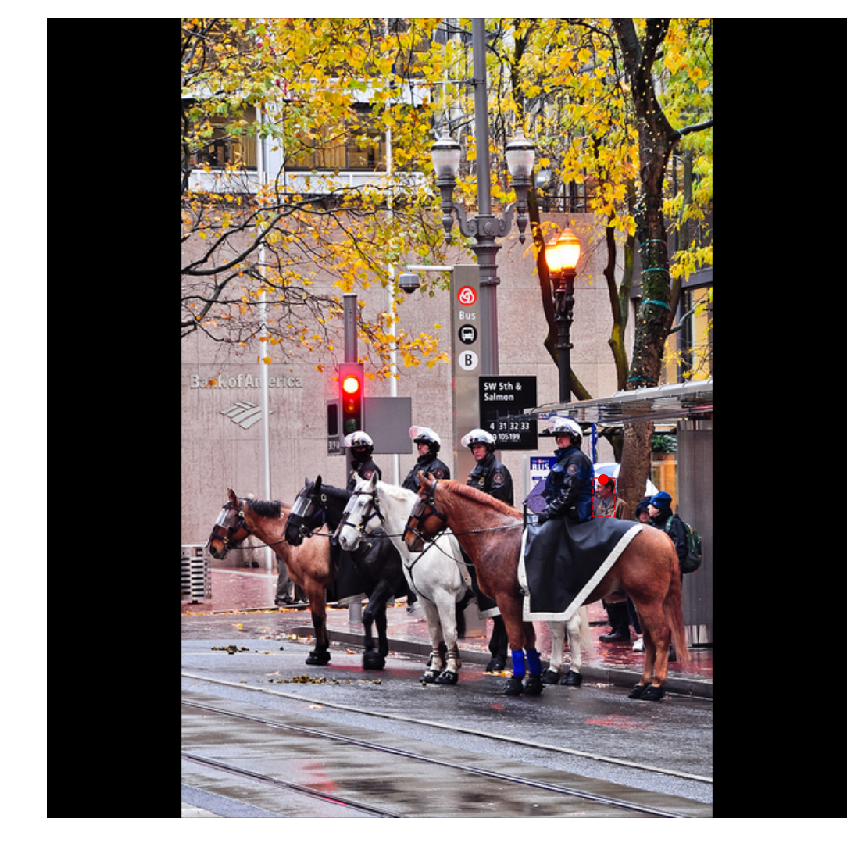

In [9]:
importlib.reload(modellib)

# Load a test image
image_id = np.random.choice(dataset_val.image_ids)

# Get ground truth masks and bboxes
image = modellib.load_image_gt(dataset_val, inference_config, image_id)[0]

results = model.detect([image], verbose=1)
r = results[0]

bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

%matplotlib inline
import matplotlib.pyplot as plt

n = np.sqrt(inference_config.NUM_KEYPOINTS)
_, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
if n <= 1: axes = np.array(axes)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= inference_config.NUM_KEYPOINTS: continue
    #x, y = i % 4, i // 4
    
    ax.set_title(dataset_train.kp_class_names[i+1])
    ax.imshow(kp_masks[0, i])


plt.show()

visualize.display_keypoints(image, bbox[0:1], kp_masks[0:1],
                            #skeleton=dataset_train.skeleton
                            figsize=(15, 15))

In [ ]:
print(r['class_ids'])
print(r["scores"])

In [ ]:
#visualize.display_keypoints(original_image, r['rois'], r['masks'], r['class_ids'],
#                            dataset_val.class_names, skeleton=None)

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
#print(det_class_ids)
#det_count = np.where(det_class_ids == 0)[0][0]
#det_class_ids = det_class_ids[:det_count]

#print("{} detections: {}".format(
#    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
"""det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)"""

In [ ]:
#visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")